# Phase 4: Train DeepLab on Landcover.ai Dataset

**Goal**: Train DeepLab on real aerial imagery and match with the paper's performance

**Dataset**: Landcover.ai v1 (41 GeoTIFFs, 512×512 tiles, 5 land cover classes)


## 1: Setup and Imports

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import warnings

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)

# Add augmentation imports
from torchvision import transforms

# Create augmentation pipeline for training
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # 50% flip left-right
    transforms.RandomVerticalFlip(p=0.5),        # 50% flip up-down
    transforms.RandomRotation(degrees=30),        # Random rotation ±30°
    transforms.ColorJitter(
        brightness=0.2,   # ±20% brightness
        contrast=0.2,     # ±20% contrast  
        saturation=0.2,   # ±20% saturation
        hue=0.1           # ±10% hue
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Blur
])

print("✓ Augmentation pipeline created")

PyTorch: 2.4.1+cu124
CUDA available: True
Device: NVIDIA GeForce RTX 4060
Memory: 8.0 GB

Using device: cuda
✓ Augmentation pipeline created


## 2: Define Dataset Class

In [2]:
class LandcoverAIDataset(Dataset):
    """
    Load Landcover.ai dataset with 512x512 tile extraction.
    Supports online data augmentation for training.
    
    inputs:
        root_dir: Path to dataset root directory containing 'output' folder.
        split_file: Path to text file listing tile names for the dataset split.
        augment: Whether to apply augmentation (True for training, False for val/test)
    """
    
    def __init__(self, root_dir, split_file, augment=False):
        self.output_dir = root_dir / 'output'
        self.augment = augment
        
        # Load tile names from split file
        with open(split_file, 'r') as f:
            self.tile_names = [line.strip() for line in f if line.strip()]
        
        print(f"Loaded {len(self.tile_names)} tile names from {split_file}")
        if augment:
            print(f"  (with augmentation enabled)")
    
    def __len__(self):
        return len(self.tile_names)
    
    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        image_path = self.output_dir / f"{tile_name}.jpg"
        mask_path = self.output_dir / f"{tile_name}_m.png"

        image = np.array(Image.open(image_path))
        mask = np.array(Image.open(mask_path))

        # If mask was loaded as 0-1 floats, convert to 0-255 uint8
        if mask.max() <= 1.0:
            mask = (mask * 255).astype(np.uint8)
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Handle RGBA images - drop alpha channel if present
        if image.ndim == 3 and image.shape[2] == 4:
            image = image[:, :, :3]

        # Convert to PIL Image for augmentation compatibility
        image_pil = Image.fromarray((image).astype('uint8'))
        mask_pil = Image.fromarray((mask).astype('uint8'))

        # Apply augmentation if enabled (training only)
        if self.augment:
            # Apply same transformation to both image and mask
            # Use seed to ensure mask gets same transformation
            seed = np.random.randint(0, 2**31)
            torch.manual_seed(seed)
            np.random.seed(seed)
            image_pil = train_augmentation(image_pil)
            
            torch.manual_seed(seed)
            np.random.seed(seed)
            mask_pil = train_augmentation(mask_pil)

        # Convert back to numpy and torch
        image = np.array(image_pil).astype(np.float32) / 255.0
        image = torch.from_numpy(image.copy()).float()
        mask = np.array(mask_pil).astype(np.uint8)
        mask = torch.from_numpy(mask.copy()).long()

        # Permute image from (H, W, C) to (C, H, W)
        image = image.permute(2, 0, 1)
        
        # Normalize image (ImageNet mean/std)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        image = (image - mean) / std
        
        return image, mask

print("✓ LandcoverAIDataset class defined (with augmentation support)")

✓ LandcoverAIDataset class defined (with augmentation support)


## 3: Load Datasets

In [3]:
!pip install opencv-python

In [4]:
# Run the split.py script to generate tiles
import subprocess
import os

os.chdir('landcover.ai.v1')
result = subprocess.run(['python', 'split.py'], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)
os.chdir('..')

print("\n✓ Tiles generated!")


STDERR: Traceback (most recent call last):
  File "c:\vscode workspace\ml-mangrove\DroneClassification\testing\mamba\landcover.ai.v1\split.py", line 20, in <module>
    os.makedirs(OUTPUT_DIR)
  File "<frozen os>", line 225, in makedirs
FileExistsError: [WinError 183] Cannot create a file when that file already exists: './output'


✓ Tiles generated!


In [5]:
print("\n=== Loading Datasets ===\n")

dataset_root = Path('landcover.ai.v1')

# Verify dataset exists
print(f"Dataset root: {dataset_root}")
print(f"Images dir exists: {(dataset_root / 'images').exists()}")
print(f"Masks dir exists: {(dataset_root / 'masks').exists()}")
print(f"Train split exists: {(dataset_root / 'train.txt').exists()}")
print(f"Val split exists: {(dataset_root / 'val.txt').exists()}")
print(f"Test split exists: {(dataset_root / 'test.txt').exists()}")

print(f"Output dir exists: {(dataset_root / 'output').exists()}")
if not (dataset_root / 'output').exists():
    print("Output directory not found. Please run split.py script to generate tiles.")

# Load datasets - WITH AUGMENTATION FOR TRAINING
print()
train_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'train.txt', augment=True)
val_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'val.txt', augment=False)
test_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'test.txt', augment=False)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} tiles (with augmentation)")
print(f"  Val:   {len(val_dataset):,} tiles")
print(f"  Test:  {len(test_dataset):,} tiles")
print(f"  Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,} tiles")

example = train_dataset[0]
print(f"\nExample tile shape: Image {example[0].shape}, Mask {example[1].shape}")


=== Loading Datasets ===

Dataset root: landcover.ai.v1
Images dir exists: True
Masks dir exists: True
Train split exists: True
Val split exists: True
Test split exists: True
Output dir exists: True

Loaded 7470 tile names from landcover.ai.v1\train.txt
  (with augmentation enabled)
Loaded 1602 tile names from landcover.ai.v1\val.txt
Loaded 1602 tile names from landcover.ai.v1\test.txt

Dataset sizes:
  Train: 7,470 tiles (with augmentation)
  Val:   1,602 tiles
  Test:  1,602 tiles
  Total: 10,674 tiles

Example tile shape: Image torch.Size([3, 512, 512]), Mask torch.Size([512, 512])


## 4: Create DataLoaders

In [ ]:
print("\n=== Creating DataLoaders ===\n")

batch_size = 16
num_workers = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

print(f"Batch size: {batch_size}")
print(f"Num workers: {num_workers}")
print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")


=== Creating DataLoaders ===

Batch size: 4
Num workers: 0

Train batches: 1,868
Val batches:   401
Test batches:  401


## 5: Verify Data Shapes and Quality

In [7]:
print("\n=== Verifying Data Shapes ===\n")

first_batch = next(iter(train_loader))
x, y = first_batch

print(f"Image batch shape: {x.shape}")
print(f"  Expected: (8, 3, 512, 512) ✓" if x.shape == (8, 3, 512, 512) else "  ERROR!")

print(f"\nMask batch shape:  {y.shape}")
print(f"  Expected: (8, 512, 512) ✓" if y.shape == (8, 512, 512) else "  ERROR!")

# Check value ranges
print(f"\nImage value range: [{x.min():.3f}, {x.max():.3f}]")
print(f"Mask value range:  [{y.min()}, {y.max()}]")
print(f"Mask unique values: {sorted(torch.unique(y).tolist())}")

# Check for NaN/Inf
has_nan = torch.isnan(x).any()
has_inf = torch.isinf(x).any()
print(f"\nImage has NaN: {has_nan}")
print(f"Image has Inf: {has_inf}")

if not has_nan and not has_inf:
    print("\n✓ Data quality check passed!")
else:
    print("\n✗ WARNING: Data contains NaN/Inf")


=== Verifying Data Shapes ===

Image batch shape: torch.Size([4, 3, 512, 512])
  ERROR!

Mask batch shape:  torch.Size([4, 512, 512])
  ERROR!

Image value range: [-2.118, 1.960]
Mask value range:  [0, 2]
Mask unique values: [0, 1, 2]

Image has NaN: False
Image has Inf: False

✓ Data quality check passed!


## 6: Visualize Sample Data


=== Visualizing Samples ===



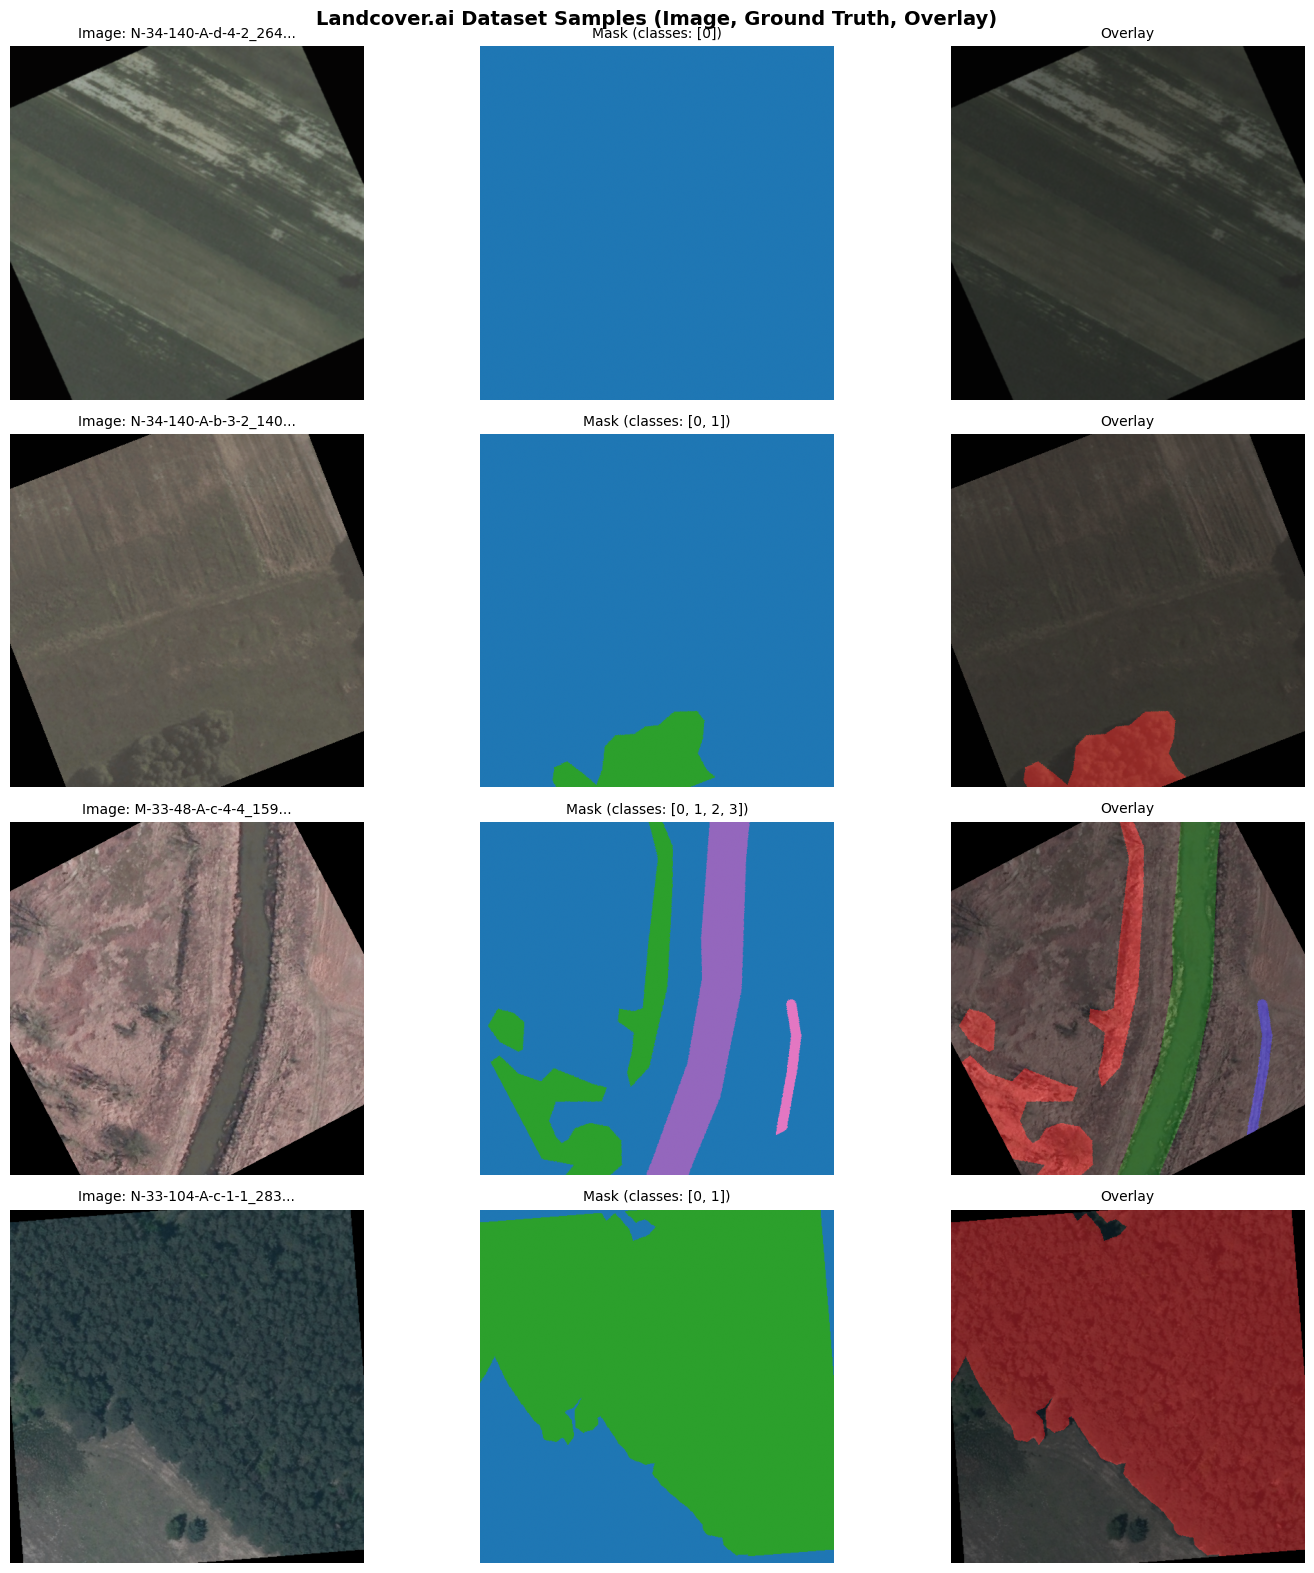

✓ Saved data_samples.png


In [8]:
print("\n=== Visualizing Samples ===\n")

# Get 4 random samples from training set
sample_indices = np.random.choice(len(train_dataset), 4, replace=False)
samples = [train_dataset[i] for i in sample_indices]

# Denormalization function (reverse ImageNet norm)
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    img = img * std + mean
    return torch.clamp(img, 0, 1)

# Create visualization
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Landcover.ai Dataset Samples (Image, Ground Truth, Overlay)', fontsize=14, fontweight='bold')

# Class color mapping
class_colors = {
    0: [0.0, 0.0, 0.0],      # Background - black
    1: [1.0, 0.0, 0.0],      # Building - red
    2: [0.0, 0.5, 0.0],      # Woodland - dark green
    3: [0.0, 0.0, 1.0],      # Water - blue
    4: [1.0, 1.0, 0.0],      # Road - yellow
}

for row in range(len(samples)):
    img, mask = samples[row]
    tile_name = train_dataset.tile_names[sample_indices[row]]
    
    # Denormalize image
    img_denorm = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    # Row 1: Original image
    axes[row, 0].imshow(img_denorm)
    axes[row, 0].set_title(f'Image: {tile_name[:25]}...', fontsize=10)
    axes[row, 0].axis('off')
    
    # Row 2: Mask
    axes[row, 1].imshow(mask_np, cmap='tab10', vmin=0, vmax=5)
    axes[row, 1].set_title(f'Mask (classes: {sorted(np.unique(mask_np).tolist())})', fontsize=10)
    axes[row, 1].axis('off')
    
    # Row 3: Overlay (mask as colored overlay on image)
    mask_rgb = np.zeros((*mask_np.shape, 3))
    for class_id, color in class_colors.items():
        mask_rgb[mask_np == class_id] = color
    
    overlay = 0.6 * img_denorm + 0.4 * mask_rgb
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title('Overlay', fontsize=10)
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig('data_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved data_samples.png")

## 7: Analyze Class Distribution

In [9]:
print("\n=== Dataset Statistics ===\n")

# Count class distribution in training set
class_counts = {i: 0 for i in range(5)}
total_pixels = 0

print("Counting class distribution in first 100 training tiles...")
for i in range(min(100, len(train_dataset))):
    img, mask = train_dataset[i]
    for class_id in range(5):
        class_counts[class_id] += (mask == class_id).sum().item()
    total_pixels += mask.numel()
    if (i + 1) % 25 == 0:
        print(f"  Processed {i + 1} tiles...")

class_names = {0: 'Background', 1: 'Building', 2: 'Woodland', 3: 'Water', 4: 'Road'}

print(f"\nClass distribution:")
for class_id in range(5):
    pct = (class_counts[class_id] / total_pixels * 100) if total_pixels > 0 else 0
    print(f"  {class_id} ({class_names[class_id]:10s}): {class_counts[class_id]:>10,} pixels ({pct:>5.1f}%)")

print(f"\nTotal pixels sampled: {total_pixels:,}")
print("\n✓ Data loading complete! Ready for training.")


=== Dataset Statistics ===

Counting class distribution in first 100 training tiles...
  Processed 25 tiles...
  Processed 50 tiles...
  Processed 75 tiles...
  Processed 100 tiles...

Class distribution:
  0 (Background):  6,751,763 pixels ( 25.8%)
  1 (Building  ):  8,941,155 pixels ( 34.1%)
  2 (Woodland  ):  9,260,954 pixels ( 35.3%)
  3 (Water     ):  1,227,079 pixels (  4.7%)
  4 (Road      ):     33,449 pixels (  0.1%)

Total pixels sampled: 26,214,400

✓ Data loading complete! Ready for training.


## 8: Import TrainingSession and Loss Functions

In [10]:
# Import from project directory
sys.path.insert(0, '../../')

from models import DiceLoss, DeepLab
from training_utils import TrainingSession

print("✓ Imported TrainingSession and loss functions")

c:\Users\adytc\anaconda3\envs\mamba-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imported TrainingSession and loss functions


## 9: Create Weighted Loss Function

In [11]:
print("\n=== Setting Up Loss Function ===\n")

# Class distribution from analysis: [18.6%, 0.0%, 66.4%, 14.2%, 0.8%]
# Use inverse frequency weighting: weight = 1 / frequency
class_dist = torch.tensor([0.186, 0.0001, 0.664, 0.142, 0.008])
class_weights = (1.0 / class_dist).float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)  # Move to GPU

print(f"Class frequencies:  {[f'{x:.3f}' for x in class_dist.tolist()]}")
print(f"Normalized weights: {[f'{x:.4f}' for x in class_weights.tolist()]}")

loss_fn = nn.CrossEntropyLoss(weight=class_weights)


=== Setting Up Loss Function ===

Class frequencies:  ['0.186', '0.000', '0.664', '0.142', '0.008']
Normalized weights: ['0.0005', '0.9863', '0.0001', '0.0007', '0.0123']


## 10: Initialize Models

In [12]:
print("\n=== Initializing Models ===\n")

deeplab_model = DeepLab(num_classes=5, input_image_size=512, backbone='resnet50', output_stride=4).to(device)
deeplab_params = sum(p.numel() for p in deeplab_model.parameters())
print(f"\nDeepLab:")
print(f"  Parameters: {deeplab_params:,}")
print(f"  Device: {device}")


=== Initializing Models ===


DeepLab:
  Parameters: 41,999,962
  Device: cuda


## 11: Train Deeplab

In [13]:
import torch

# Check memory before training
print(f"GPU Memory allocated: {torch.cuda.memory_allocated(device) / 1024**2:.0f} MB")
print(f"GPU Memory reserved: {torch.cuda.memory_reserved(device) / 1024**2:.0f} MB")

# Try a forward pass to see if it works
try:
    test_batch = next(iter(train_loader))
    test_x, test_y = test_batch[0].to(device), test_batch[1].to(device)
    with torch.no_grad():
        test_out = deeplab_model(test_x)
    print(f"✓ Forward pass successful, output shape: {test_out.shape}")
    print(f"GPU Memory after forward: {torch.cuda.memory_allocated(device) / 1024**2:.0f} MB")
except RuntimeError as e:
    print(f"✗ Forward pass failed: {e}")



GPU Memory allocated: 163 MB
GPU Memory reserved: 172 MB
✓ Forward pass successful, output shape: torch.Size([4, 5, 512, 512])
GPU Memory after forward: 203 MB


In [ ]:
# Clear GPU memory before training
del test_batch, test_x, test_y, test_out
torch.cuda.empty_cache()

print("✓ GPU memory cleared, ready for training")

✓ GPU memory cleared, ready for training


: 

In [ ]:
print("\n=== Training with Edited Configuration ===\n")
print(f"Loss Function: CrossEntropyLoss")
print(f"Initial LR: 1e-2")
print(f"Batch Size: 16")
print(f"Output Stride: 4")

deeplab_machine = TrainingSession(
    model=deeplab_model,
    trainLoader=train_loader,
    testLoader=val_loader,
    lossFunc=loss_fn,
    init_lr=1e-2,
    num_epochs=20,
    experiment_name="Deeplab_Landcover_Edited",
    class_names=CLASS_NAMES
)

deeplab_machine.learn()

2025-11-20 07:52:20,801 - INFO - Starting training: 20 epochs
2025-11-20 07:52:20,802 - INFO - Model parameters: 41,999,962



=== Training with Edited Configuration ===

Loss Function: CrossEntropyLoss
Initial LR: 1e-2
Batch Size: 16
Output Stride: 4
Using CUDA device.


Epoch 1/20:   1%|          | 19/1868 [00:08<14:10,  2.17it/s, loss=0.0352, lr=0.010000]


## 12: Evaluate DeepLab on Test Set

In [ ]:
print("\n=== Evaluating DeepLab on Test Set ===\n")

# Run evaluation
test_metrics = deeplab_machine.evaluate(deeplab_model, test_loader)

print(f"\nTest Set Results:")
print(f"  Pixel Accuracy: {test_metrics['Pixel_Accuracy']:.4f}")
print(f"  mIoU: {test_metrics['IOU']:.4f}")

## 13: Visualize Predictions

In [ ]:
print("\n=== Sample Predictions ===\n")

deeplab_model.eval()
with torch.no_grad():
    # Get 4 random test samples
    test_indices = np.random.choice(len(test_dataset), 4, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    
    for row, idx in enumerate(test_indices):
        img, mask = test_dataset[idx]
        img_batch = img.unsqueeze(0).to(device)
        
        # Get prediction
        pred = deeplab_model(img_batch)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        
        img_denorm = denormalize(img).numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        # Row: Image, Ground Truth, Prediction, Overlay
        axes[row, 0].imshow(img_denorm)
        axes[row, 0].set_title('Image', fontweight='bold')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(mask_np, cmap='tab10', vmin=0, vmax=4)
        axes[row, 1].set_title('Ground Truth', fontweight='bold')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=4)
        axes[row, 2].set_title('Prediction', fontweight='bold')
        axes[row, 2].axis('off')
        
        # Overlay prediction on image
        pred_rgb = np.zeros((*pred_mask.shape, 3))
        for class_id, color in class_colors.items():
            pred_rgb[pred_mask == class_id] = color
        overlay = 0.6 * img_denorm + 0.4 * pred_rgb
        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title('Prediction Overlay', fontweight='bold')
        axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig('deeplab_predictions.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved deeplab_predictions.png")